In [1]:
from __future__ import division

import collections
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## NN libs
import keras
from keras import backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import TensorBoard

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# local libs
import config, models, setup
import midi
from midi import generators as g
from utils import io, models_io, utils, plot
from capsule.layers import Capsule, Length
from capsule.capsulefunctions import squash, softmax, margin_loss

In [4]:
context = setup.init()

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_timestesp = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]

Setting up params

max min f 10.0 0.5
 >> Context(max_t=2.0, dt=0.05, n_timesteps=40, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
 sample length:  40.000000
 max_f: 10.000000, min_f: 0.500000


In [5]:
mido.Message(type='note_on').type

'note_on'

In [132]:
n = 500 * 1
dim4 = True
multiTrack = True
reduce_dims = midi.ReduceDimsOptions.MIDIFILE # GLOBAL
dn = 'drum_midi/'
v = 1.
x_train, labels = setup.import_data(context, n, dim4=dim4, reduce_dims=reduce_dims, 
    dirname=dn, multiTrack=multiTrack, velocity=v, r=True)


Importing midi-data

Encoding midi-data
 500
> -> multi-track = True MidiFile
 [INFO] : 
 |  True


In [133]:
[(i,k) for i,k in enumerate(labels)]

[(0,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/01 8th Hat.mid"),
 (1,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/02 8th Ride.mid"),
 (2,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/03 16th Snare.mid"),
 (3,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/04 8th Ride.mid"),
 (4,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/05 16th Ride.mid"),
 (5,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/06 16th Ride.mid"),
 (6,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/07 16th Ride.mid"),
 (7,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM/01 8th Hat.mid"),
 (8,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM/02 8th Snare.mid"),
 (9,
  "../

In [134]:
x_train.shape

(500, 40, 9, 1)

In [135]:
m = int(x_train.shape[0] * 0.9)
x_train.shape, m

((500, 40, 9, 1), 450)

In [136]:
x_test = x_train[m:]
x_train = x_train[:m]

m (40, 9)


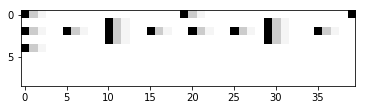

m (40, 9)


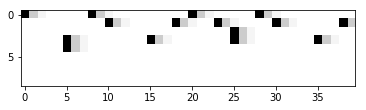

array(["../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/01 8th Hat.mid",
       '../datasets/drum_midi//50´s Drummer MIDI Files/06 Soul - Funk/08 Rim Soul 90BPM/01 4th Hat.mid'],
      dtype='<U106')

In [137]:
i = 0
j = 399
plot.single(x_train[i, :50,:,0])
plot.single(x_train[j, :50,:,0])
# plot.single(x_train[2, :50,:,0])
np.array(labels)[[i,j]]

In [138]:
input_shape = x_train[0].shape
timesteps = input_shape[0]
notes = input_shape[1]
input_shape

(40, 9, 1)

In [139]:
latent_dim = 10
intermediate_dim = 128
epsilon_std = 1.0

In [140]:
def encoder(input_shape, dropout=0.1):
    encoder_input = Input(shape=input_shape)
    nodes = np.prod(input_shape)
    timesteps, notes, channels = input_shape
    
    # Convolution
    h = encoder_input
    k = (2,1)
    s = (2,1)
    
    h = Reshape((timesteps, notes))(h)
    h = Conv1D(64, kernel_size=2, strides=1, activation='relu', padding='valid')(h)
    
    h = Bidirectional(LSTM(128))(h)

    # Z Mean, Variance
    z_mean = Dense(latent_dim, name='z_mean')(h) # , activation='relu'
    z_log_var = Dense(latent_dim, name='z_log_var')(h) # , activation='relu'
        
    encoder_output = [z_mean, z_log_var]
    encoder_model = Model(encoder_input, encoder_output, name='encoder_model-')
#     print('Extra params:', [k.count_params() for k in [rnn, reshape, capsule]])

    return encoder_model, encoder_input, z_mean, z_log_var

In [141]:
encoder_model, encoder_input, z_mean, z_log_var = encoder(input_shape)
encoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 40, 9, 1)     0                                            
__________________________________________________________________________________________________
reshape_17 (Reshape)            (None, 40, 9)        0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 39, 64)       1216        reshape_17[0][0]                 
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 256)          197632      conv1d_5[0][0]                   
__________________________________________________________________________________________________
z_mean (De

In [142]:
sample_ = lambda args: models.sample(args, z_mean, z_log_var, latent_dim, epsilon_std)

In [143]:
# z = Lambda(sampling)([z_mean, z_log_var])
z_input = encoder_model(encoder_input)
z_output = Lambda(sample_)(z_input)
# z_output = Lambda(sampl_, output_shape=(latent_dim,))(encoder_input)

In [144]:
def list_decoders(output_shape):
    # decoder_input = z_output
    # h = decoder_input
    # :output_shape = (timesteps, channels, channels) || (batches, filters, timesteps, channels)
    # keras offers just Conv2DTranspose and not Conv1DTranspose
    # - use 2D images during upsampling :: (timesteps, notes, channels) => (timesteps, notes, filters)
    # - use 1D images to optimize reconstruction :: (timesteps, filters) => (timesteps, notes)
    
    # image_data_format = 'channels_last'
    # goal shape: (timesteps, notes, channels)
    # start with the 'reverse': lots of small imgs => few large img
    
    timesteps, notes, channels = output_shape

    # keras.examples.variational_autoencoder_deconv.py
    decoders = []
    decoders += [ Dense(256) ]
    decoders += [ LeakyReLU(alpha=0.3) ]
    
    # add a bypass layer
    w = 256
    decoders += [ Dense(w, activation='relu') ]
    extra_decoders = []
    for _ in range(3):
        extra_decoders += [ Dense(w, activation='elu', bias_initializer='zeros') ]

    extra_d = Lambda(lambda layer: utils.composition(extra_decoders, layer))
    decoders += [ Lambda(lambda layer: Add()([layer, extra_d(layer)])) ]
    
    decoders += [ BatchNormalization(momentum=0.5) ]

    n = 4
    dim1, dim2, filters = n, int(timesteps/n), 250
    decoders += [ Reshape((n, int(w/n))) ]
    decoders += [ TimeDistributed(Dense(filters, activation='relu')) ]
    print(n*w/timesteps, timesteps, filters, n, timesteps*n*w/timesteps)
#     decoders += [ Reshape((timesteps, int(n*filters/timesteps) )) ]
#     decoders += [ Reshape((int(timesteps * filters*n/timesteps),)) ]
    decoders += [ Reshape((timesteps, int(filters*n/timesteps),)) ]
#     decoders += [ Reshape((40, 256)) ]

    decoders += [ TimeDistributed(Dense(notes, activation='sigmoid')) ]
    decoders += [ Reshape((timesteps, notes, 1)) ]

    return decoders

In [145]:
decoders = list_decoders(input_shape)

25.6 40 250 4 1024.0


In [146]:
decoded = utils.composition(decoders, z_output, verbose=False)
# layer1, = layers

In [147]:
# layer1.output

In [148]:
# instantiate VAE model
vae_input = encoder_input
vae_output = decoded
vae = Model(vae_input, vae_output)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 40, 9, 1)     0                                            
__________________________________________________________________________________________________
encoder_model- (Model)          [(None, 10), (None,  203988      input_7[0][0]                    
__________________________________________________________________________________________________
lambda_14 (Lambda)              (None, 10)           0           encoder_model-[1][0]             
                                                                 encoder_model-[1][1]             
__________________________________________________________________________________________________
dense_29 (Dense)                (None, 256)          2816        lambda_14[0][0]                  
__________

In [149]:
# Compute VAE loss
def vae_loss(beta=1.):
#     beta = ((1.0 - tf.pow(hparams.beta_rate, tf.to_float(self.global_step)))
#             * hparams.max_beta)
#     self.loss = tf.reduce_mean(r_loss) + beta * tf.reduce_mean(kl_cost)
    # y_true, y_pred, z_mean, z_log_var, timesteps=150, notes=3, beta=1.
    xent_loss = timesteps * notes * keras.metrics.binary_crossentropy(K.flatten(vae_input), K.flatten(vae_output))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    # kl_loss = max(kl_loss, free_bits)
    vae_loss = K.mean(xent_loss + beta * kl_loss)
    return vae_loss

vae_loss = vae_loss(beta=0.5)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
# vae.compile(optimizer=optimizer, loss=loss, metrics=metrics)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Output "reshape_20" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "reshape_20" during training.
  from ipykernel import kernelapp as app


In [150]:
K.int_shape(z_mean)

(None, 10)

In [151]:
batch_size = 100
epochs = 500
params = {'batch_size': batch_size, 'return_y': False}

In [152]:
phase_mod = 0.01
whitening = False

In [153]:
m = 25
useDataGenerator = False
# useDataGenerator = True

x = x_train[:m]
# x = x_train
# i = [0,1, 7,8, 14,15, 399,400]
# x_ = x_train[i]
# x = np.concatenate([x_ for _ in range(50)])
print('x:', x.shape)

print('batch_size =', batch_size)
if useDataGenerator:
    datagen = models.ImageDataGenerator(x_train, batch_size, phase_mod, whitening)
    history = collections.defaultdict(list)
    n_batches = datagen.__len__()
    for e in range(epochs):
        print('\n[Epoch %i/%i] >>>>>>>>>' % (e, epochs))
        for batch_i, (x_batch, y_batch) in enumerate(datagen.flow(x, x, batch_size)):
            print(' Batch %i/%i' % (batch_i,n_batches))
            x_ = x_batch
            # x_ = datagen.shuffle_3rd_dim(x_)
            x_ = datagen.shuffle_3rd_dim_soft(x_, rate=0.5, scale=0.1, verbose=0)
            h = vae.fit(x_, validation_data=(x_test, None), verbose=0)
            for k,v in h.history.items(): 
                print(' \\_%s' % k, [round(v_,) for v_ in v])
                history[k].append(v)
            if batch_i >= n_batches:
                break
else:
    h = vae.fit(x, epochs=epochs, validation_data=(x_test, None))
    history = h.history

x: (25, 40, 9, 1)
batch_size = 100
Train on 25 samples, validate on 50 samples
Epoch 1/500
25/25 [==============================] - 6s 232ms/step - loss: 243.1344 - val_loss: 241.8274
Epoch 2/500
25/25 [==============================] - 0s 6ms/step - loss: 241.0639 - val_loss: 239.3083
Epoch 3/500
25/25 [==============================] - 0s 7ms/step - loss: 237.9586 - val_loss: 236.8372
Epoch 4/500
25/25 [==============================] - 0s 6ms/step - loss: 235.9649 - val_loss: 234.1569
Epoch 5/500
25/25 [==============================] - 0s 7ms/step - loss: 232.6392 - val_loss: 231.8683
Epoch 6/500
25/25 [==============================] - 0s 6ms/step - loss: 230.5068 - val_loss: 230.2963
Epoch 7/500
25/25 [==============================] - 0s 6ms/step - loss: 227.9597 - val_loss: 226.7047
Epoch 8/500
25/25 [==============================] - 0s 6ms/step - loss: 225.4776 - val_loss: 224.9482
Epoch 9/500
25/25 [==============================] - 0s 6ms/step - loss: 223.5453 - val_loss: 2

Epoch 80/500
25/25 [==============================] - 0s 6ms/step - loss: 86.3413 - val_loss: 92.1816
Epoch 81/500
25/25 [==============================] - 0s 6ms/step - loss: 83.4432 - val_loss: 91.6172
Epoch 82/500
25/25 [==============================] - 0s 5ms/step - loss: 86.6638 - val_loss: 90.9662
Epoch 83/500
25/25 [==============================] - 0s 6ms/step - loss: 81.2652 - val_loss: 89.6852
Epoch 84/500
25/25 [==============================] - 0s 8ms/step - loss: 77.1866 - val_loss: 90.3652
Epoch 85/500
25/25 [==============================] - 0s 5ms/step - loss: 78.5810 - val_loss: 89.0967
Epoch 86/500
25/25 [==============================] - 0s 6ms/step - loss: 78.1175 - val_loss: 87.9649
Epoch 87/500
25/25 [==============================] - 0s 6ms/step - loss: 79.7461 - val_loss: 92.0413
Epoch 88/500
25/25 [==============================] - 0s 6ms/step - loss: 74.5629 - val_loss: 87.6074
Epoch 89/500
25/25 [==============================] - 0s 6ms/step - loss: 73.3683 

Epoch 160/500
25/25 [==============================] - 0s 6ms/step - loss: 54.5532 - val_loss: 73.9167
Epoch 161/500
25/25 [==============================] - 0s 6ms/step - loss: 54.9598 - val_loss: 73.9832
Epoch 162/500
25/25 [==============================] - 0s 6ms/step - loss: 54.1743 - val_loss: 73.7896
Epoch 163/500
25/25 [==============================] - 0s 6ms/step - loss: 55.8402 - val_loss: 76.0184
Epoch 164/500
25/25 [==============================] - 0s 6ms/step - loss: 59.6573 - val_loss: 76.0487
Epoch 165/500
25/25 [==============================] - 0s 7ms/step - loss: 56.5636 - val_loss: 75.2731
Epoch 166/500
25/25 [==============================] - 0s 6ms/step - loss: 55.3716 - val_loss: 75.3327
Epoch 167/500
25/25 [==============================] - 0s 6ms/step - loss: 54.7988 - val_loss: 75.4212
Epoch 168/500
25/25 [==============================] - 0s 6ms/step - loss: 53.9169 - val_loss: 75.3490
Epoch 169/500
25/25 [==============================] - 0s 6ms/step - loss

Epoch 240/500
25/25 [==============================] - 0s 6ms/step - loss: 50.0125 - val_loss: 74.3003
Epoch 241/500
25/25 [==============================] - 0s 6ms/step - loss: 49.9790 - val_loss: 74.6974
Epoch 242/500
25/25 [==============================] - 0s 6ms/step - loss: 49.6362 - val_loss: 71.2436
Epoch 243/500
25/25 [==============================] - 0s 6ms/step - loss: 49.3938 - val_loss: 72.1112
Epoch 244/500
25/25 [==============================] - 0s 6ms/step - loss: 50.2332 - val_loss: 72.5555
Epoch 245/500
25/25 [==============================] - 0s 7ms/step - loss: 49.3438 - val_loss: 72.3243
Epoch 246/500
25/25 [==============================] - 0s 6ms/step - loss: 49.3426 - val_loss: 73.4465
Epoch 247/500
25/25 [==============================] - 0s 6ms/step - loss: 50.3028 - val_loss: 72.9105
Epoch 248/500
25/25 [==============================] - 0s 6ms/step - loss: 51.2115 - val_loss: 74.1054
Epoch 249/500
25/25 [==============================] - 0s 6ms/step - loss

Epoch 320/500
25/25 [==============================] - 0s 6ms/step - loss: 44.7381 - val_loss: 73.1955
Epoch 321/500
25/25 [==============================] - 0s 6ms/step - loss: 43.3267 - val_loss: 74.6706
Epoch 322/500
25/25 [==============================] - 0s 6ms/step - loss: 43.9977 - val_loss: 74.9175
Epoch 323/500
25/25 [==============================] - 0s 6ms/step - loss: 42.7398 - val_loss: 75.1630
Epoch 324/500
25/25 [==============================] - 0s 6ms/step - loss: 43.0635 - val_loss: 72.6812
Epoch 325/500
25/25 [==============================] - 0s 6ms/step - loss: 43.5497 - val_loss: 74.4379
Epoch 326/500
25/25 [==============================] - 0s 6ms/step - loss: 43.0962 - val_loss: 73.5807
Epoch 327/500
25/25 [==============================] - 0s 6ms/step - loss: 44.6101 - val_loss: 72.2495
Epoch 328/500
25/25 [==============================] - 0s 6ms/step - loss: 42.5951 - val_loss: 72.7692
Epoch 329/500
25/25 [==============================] - 0s 6ms/step - loss

Epoch 400/500
25/25 [==============================] - 0s 7ms/step - loss: 38.0476 - val_loss: 72.8967
Epoch 401/500
25/25 [==============================] - 0s 7ms/step - loss: 37.1353 - val_loss: 72.8986
Epoch 402/500
25/25 [==============================] - 0s 6ms/step - loss: 37.5060 - val_loss: 70.8097
Epoch 403/500
25/25 [==============================] - 0s 7ms/step - loss: 38.4409 - val_loss: 72.8650
Epoch 404/500
25/25 [==============================] - 0s 6ms/step - loss: 39.8940 - val_loss: 73.6116
Epoch 405/500
25/25 [==============================] - 0s 7ms/step - loss: 38.7599 - val_loss: 73.1642
Epoch 406/500
25/25 [==============================] - 0s 6ms/step - loss: 38.3776 - val_loss: 72.6987
Epoch 407/500
25/25 [==============================] - 0s 6ms/step - loss: 38.2831 - val_loss: 71.1355
Epoch 408/500
25/25 [==============================] - 0s 6ms/step - loss: 38.4461 - val_loss: 72.0342
Epoch 409/500
25/25 [==============================] - 0s 6ms/step - loss

Epoch 480/500
25/25 [==============================] - 0s 6ms/step - loss: 34.6910 - val_loss: 75.1269
Epoch 481/500
25/25 [==============================] - 0s 6ms/step - loss: 32.8183 - val_loss: 74.6571
Epoch 482/500
25/25 [==============================] - 0s 6ms/step - loss: 32.7855 - val_loss: 74.5674
Epoch 483/500
25/25 [==============================] - 0s 6ms/step - loss: 32.8283 - val_loss: 72.7656
Epoch 484/500
25/25 [==============================] - 0s 6ms/step - loss: 32.8673 - val_loss: 74.1400
Epoch 485/500
25/25 [==============================] - 0s 5ms/step - loss: 32.6281 - val_loss: 74.0646
Epoch 486/500
25/25 [==============================] - 0s 6ms/step - loss: 32.1140 - val_loss: 72.9391
Epoch 487/500
25/25 [==============================] - 0s 6ms/step - loss: 33.3594 - val_loss: 74.0884
Epoch 488/500
25/25 [==============================] - 0s 6ms/step - loss: 33.0017 - val_loss: 74.6956
Epoch 489/500
25/25 [==============================] - 0s 6ms/step - loss

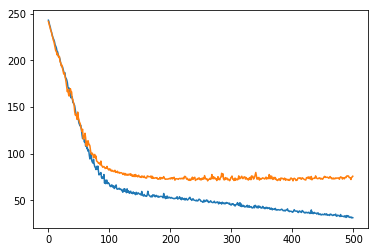

In [155]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])

In [156]:
x = x_train
x1 = x_train[0] # 0
x2 = x_train[399] # 399
x_ = [x1,x2] # x_train[:m]
x = np.concatenate([x_ for _ in range(100)])

In [157]:
x.shape

(200, 40, 9, 1)

In [158]:
x_[0].shape

(40, 9, 1)

m (40, 9)


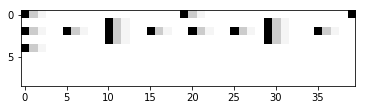

m (40, 9)


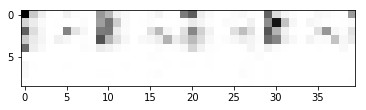

m (40, 9)


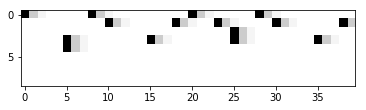

m (40, 9)


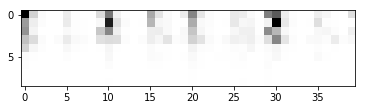

In [159]:
i = 0
j = 9
y = vae.predict(x[:10])
plot.single(x[i, :50, :, 0])
plot.single(y[i, :50, :, 0])
plot.single(x[j, :50, :, 0])
plot.single(y[j, :50, :, 0])

In [160]:
# x = datagen.shuffle_3rd_dim_soft(x_train[:10], rate=1, intensity=2, scale=1, verbose=1)
# i = 0
# plot.single(x_train[i,:,:,0])
# plot.single(x[i,:,:,0])
# x_ = vae.predict(x)
# plot.single(x_[i,:,:,0])

In [161]:
x.shape

(200, 40, 9, 1)

m (30, 9)


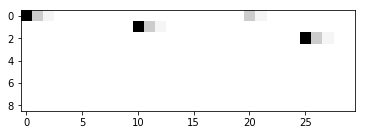

In [162]:
# min: these pixels are 'always' active
m = x.min(axis=0)
plot.multi(m[:30,:,0])

m (30, 9)


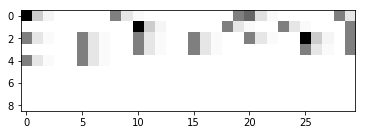

In [163]:
# mean
m = x.mean(axis=0)
plot.single(m[:30,:,0])

## Encoder + Generator
A model to project inputs on the latent space

In [164]:
# build a model to project inputs on the latent space
encoder = Model(encoder_input, z_mean)

In [165]:
x_test.shape

(50, 40, 9, 1)

In [166]:
m = 100
x_train_encoded = encoder.predict(x_train[:m], batch_size=batch_size)
x_train_encoded.shape

(100, 10)

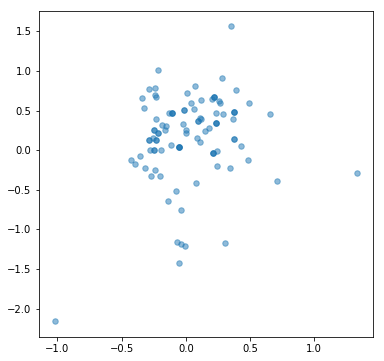

In [167]:
# y_test = range(x_train_encoded.shape[0])
y_test = np.concatenate([list(range(n)) for _ in range(int(m/n)+1)])[:m] / n
plt.figure(figsize=(6, 6))
plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1], alpha=0.5, s=30) # c=y_test, 

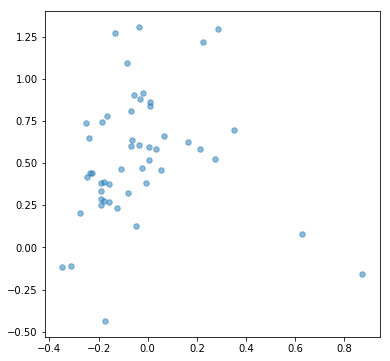

In [168]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], alpha=0.5, s=30) # , c=y_test
# plt.colorbar()

In [169]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_decoded = utils.composition(decoders, decoder_input, verbose=False)
generator = Model(decoder_input, _decoded)

In [170]:
# x_decoded[0].reshape(150,3)

In [171]:
x_train.shape

(450, 40, 9, 1)

(10,) [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


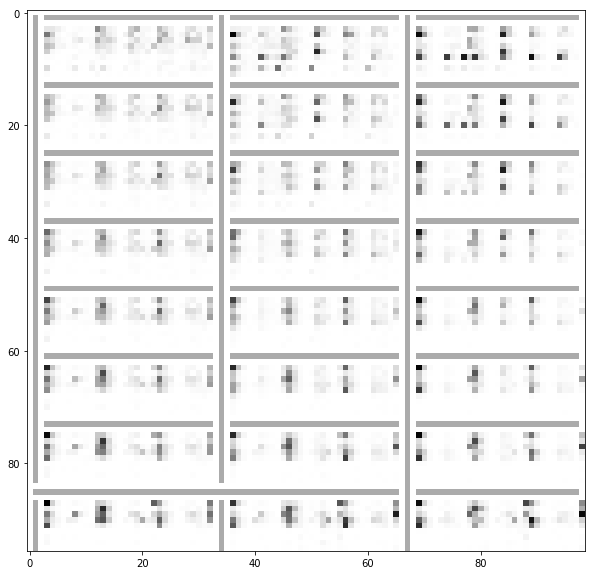

In [172]:
min_y = 0.01
max_y = 0.5
plot.latent(generator, batch_size, latent_dim,
       n=8,
       m=3,
       crop_size=30,
       margin_top=1,
       margin_left=1,
       min_x=0.05,
       max_x=0.95,
       min_y=min_y,
       max_y=max_y)

(10,) [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


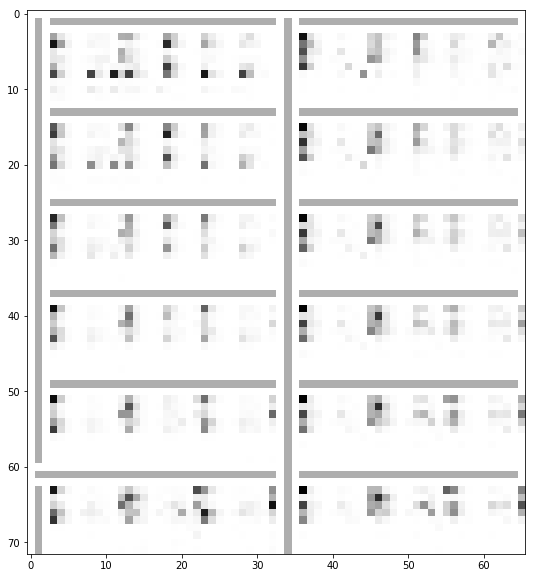

In [173]:
min_y2 = max_y
plot.latent(generator, batch_size, latent_dim,
       n=6,
       m=2,
       crop_size=30,
       margin_top=1,
       margin_left=1,
       min_x=0.05,
       max_x=0.95,
       min_y=min_y2,
       max_y=0.95)